In [9]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

In [10]:
def get_gradients(model, inputs, top_pred_idx=None):
    """
    Computes the gradients of outputs w.r.t input image.

    Args:
        model: The neural network model.
        inputs: 2D/3D/4D tensor of samples.
        top_pred_idx: (optional) Predicted label for the inputs
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t inputs.
    """
    # Ensure inputs are of type float and require gradients
    inputs = inputs.clone().detach().float()
    inputs.requires_grad = True

    # Forward pass
    preds = model(inputs)

    # For classification, grab the top class
    if top_pred_idx is not None:
        preds = preds[:, top_pred_idx]

    # Backward pass to compute gradients
    preds.backward(torch.ones_like(preds))

    # Retrieve the gradients of the inputs
    grads = inputs.grad
    return grads


def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = torch.tensor(np.zeros(input_size).astype(np.float32)).to(device)
    else:
        baseline = torch.tensor(baseline.astype(np.float32)).to(device)

    # 1. Do interpolation.
    inputs = inputs.float()
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    # interpolated_inputs = torch.tensor(interpolated_inputs)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(model,x_data, top_pred_idx=top_pred_idx).cpu().numpy()     
        grads.append(grad)
    grads = np.asarray(grads)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = torch.mean(torch.from_numpy(grads).to(device), dim=0)
    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

In [11]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-PCIE-40GB
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.1 GB
Cached:    3.2 GB
using device:  cuda


In [28]:
PATH = 'saved_models/benchmark/model003.pt'
model = torch.load(PATH).to(device)
# model.eval()

In [29]:
dir_fil = '/glade/work/wchapman/ViT_XAI/Data_Staging/Mamalakis_Dataset/scp_synth_exm_data.nc'
Data_ = xr.open_dataset(dir_fil)
Data_train = np.expand_dims(Data_['SSTrand'].isel(time=slice(0,900000)),1)
Y_train = np.array(Data_['y'].isel(time=slice(0,900000)))

Data_val = np.expand_dims(Data_['SSTrand'].isel(time=slice(950000,1000000)),1)
Y_val = np.array(Data_['y'].isel(time=slice(950000,1000000)))

Data_test = np.expand_dims(Data_['SSTrand'].isel(time=slice(900000,950000)),1)
Y_test = np.array(Data_['y'].isel(time=slice(900000,950000)))

In [30]:
sample = torch.nan_to_num(torch.tensor(Data_val[29475], dtype=torch.float32, requires_grad=True)).to(device)

In [31]:
Grad_heatmap = get_gradients(model,sample.unsqueeze(0)).cpu().numpy()
GtI_heatmap = np.multiply(Grad_heatmap,sample.unsqueeze(0).cpu().detach().numpy())
IntegratedGrad_zeros_heatmap=get_integrated_gradients(sample.unsqueeze(0)).cpu().detach().numpy()

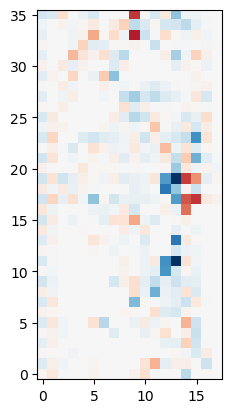

In [32]:
plt.imshow(IntegratedGrad_zeros_heatmap.squeeze(),origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01)

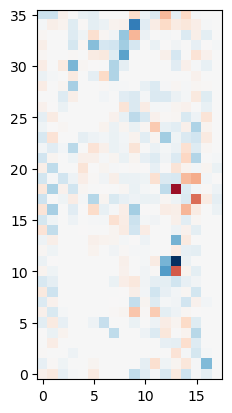

In [33]:
plt.imshow(GtI_heatmap.squeeze(),origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01)

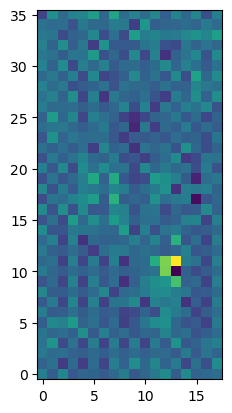

In [34]:
plt.imshow(Grad_heatmap.squeeze(),origin='lower')